In [4]:
import sys
sys.path.append('C:/Users/mechadmin/Documents/GitHub/pyiga/nurbs_models')
from model_structure import NURBSGenerator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pyiga.geometry import *
from pyiga import approx, bspline

['C:\\Users\\mechadmin\\AppData\\Local\\Programs\\Python\\Python38\\python38.zip', 'C:\\Users\\mechadmin\\AppData\\Local\\Programs\\Python\\Python38\\DLLs', 'C:\\Users\\mechadmin\\AppData\\Local\\Programs\\Python\\Python38\\lib', 'C:\\Users\\mechadmin\\AppData\\Local\\Programs\\Python\\Python38', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv', '', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages\\pyiga-0.1.0-py3.8-win-amd64.egg', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages\\appdirs-1.4.4-py3.8.egg', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\.venv\\lib\\site-packages\\Pythonwin', 'C:/Users/mechadmin/Documents/GitHub/pyiga/nurbs_models', 'C:/Users/mechadmin/Documents/Git

Model loaded successfully.


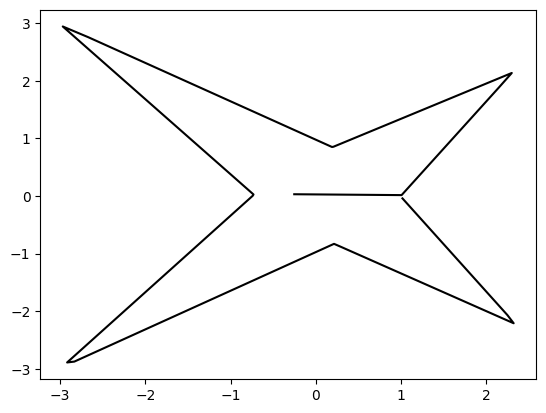

In [6]:

degree = 3
n_kv = 9
# knotvector = np.concatenate(([0] * (degree + 1), np.linspace(0, 1, num_ctrlpts - degree), [1] * (degree + 1)))
knotvector = bspline.make_knots(1, 0.0, 1.0, n_kv)
num_ctrlpts = knotvector.numdofs
input_dim = 4  # Superformula parameters
output_dim = num_ctrlpts * 2 + num_ctrlpts  # Control points and weights

# Initialize the model structure
model = NURBSGenerator(input_dim, output_dim, degree, num_ctrlpts)

# Load the saved model weights
model.load_state_dict(torch.load('C:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\nurbs_generator.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

# Use the model to generate NURBS control points and weights from new superformula parameters
new_params = torch.tensor([0.5, 20, 4, 0.3], dtype=torch.float32)
output = model(new_params)
ctrlpts, weights = output.split([num_ctrlpts*2, num_ctrlpts])
ctrlpts = ctrlpts.view(num_ctrlpts, 2)
weights = weights.view(num_ctrlpts)



# Calculate NURBS points using custom function
# nurbs_points = calculate_nurbs_points(ctrlpts, weights, knotvector, degree)
from pyiga.geometry import *
from pyiga import approx, bspline
from pyiga import bspline, assemble, vform, geometry, vis, solvers
ctrlpts_np = ctrlpts.detach().numpy()
weights_np = weights.detach().numpy()

nurbs = NurbsFunc((knotvector,), ctrlpts_np.copy(), weights=weights_np)
vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
# plt.axis('equal');


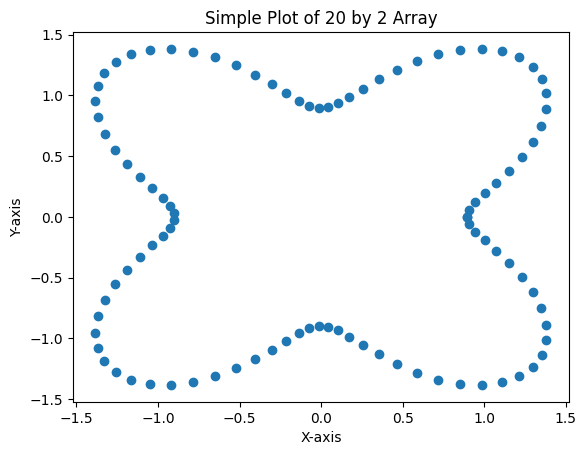

In [16]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(r, L0, n, a=0.5, d=1, num_res=100):
    theta = np.linspace(0, 2 * np.pi, num_res)
    c = cal_c(r,a,L0)
    result = c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return np.vstack((x, y)).T
res = superformula(0.5, 20, 4, 0.3)
# Plot the data
plt.plot(res[:, 0], res[:, 1], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of 20 by 2 Array')
plt.show()


In [17]:
print(weights)

tensor([ 0.1407, 30.8151,  3.6734,  3.5677,  0.4548,  1.0403,  0.4383,  3.5248,
         3.5193, 33.2298], grad_fn=<ViewBackward0>)


In [9]:
print(len(ctrlpts_np[0]))

2


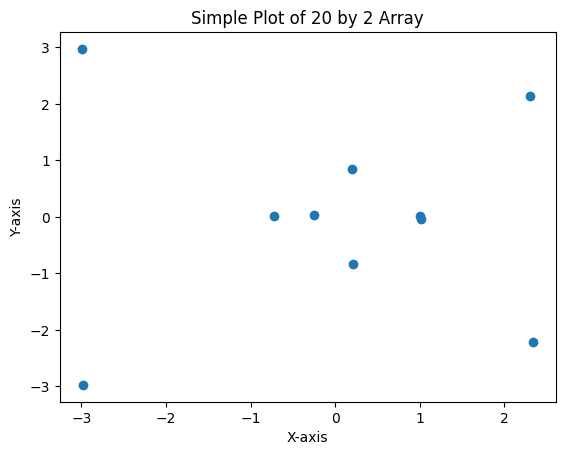

In [10]:

# Plot the data
plt.plot(ctrlpts_np[:, 0], ctrlpts_np[:, 1], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of 20 by 2 Array')
plt.show()
